<a href="https://colab.research.google.com/github/YCCS-Summer-2023-DDNMA/project/blob/main/final_code/XOR_NN_JC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

try:
    import flax.linen as nn
except ModuleNotFoundError:
    print('installing flax')
    %pip install -qq flax
import flax.linen as nn

from dynamax.generalized_gaussian_ssm import ParamsGGSSM, EKFIntegrals, UKFIntegrals, GHKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_filter

import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.optimize import minimize

print_verbose = False

from typing import Sequence
from functools import partial

import matplotlib.cm as cm
import random
import seaborn as sns
import numpy as np
from jax.flatten_util import ravel_pytree

In [2]:
def generate_dataset(num_points=2000, shuffle=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key0, key1, key2 = jr.split(key, 3)

    # Generate standardized noisy inputs that correspond to output '0'
    num_zero_points1 = num_points // 4
    zero_input1 = jnp.array([[-2., -2.]] * num_zero_points1)
    zero_input1 += jr.normal(key0, (num_zero_points1, 2))
    num_zero_points2 = num_points // 4
    zero_input2 = jnp.array([[2., 2.]] * num_zero_points2)
    zero_input2 += jr.normal(key0, (num_zero_points2, 2))

    # Generate standardized noisy inputs that correspond to output '1'
    num_one_points1 = num_points // 4
    one_input1 = jnp.array([[-2., 2.]] * num_one_points1)
    one_input1 += jr.normal(key1, (num_one_points1, 2))
    num_one_points2 = num_points // 4
    one_input2 = jnp.array([[2., -2.]] * num_one_points2)
    one_input2 += jr.normal(key1, (num_one_points2, 2))


    # Stack the inputs and add bias term
    input = jnp.concatenate([zero_input1, one_input1, zero_input2, one_input2])
    input_with_bias = jnp.concatenate([jnp.ones((num_points, 1)), input], axis=1)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros((num_zero_points1)), jnp.ones((num_one_points1)), jnp.zeros((num_zero_points2)), jnp.ones((num_one_points2))])


    #num_zero_points = jnp.concatenate([zero_input1, zero_input2])
    #num_one_points = jnp.concatenate([num_one_points1, num_one_points2])
    #output = jnp.concatenate([jnp.zeros((num_zero_points)), jnp.ones((num_one_points))])



    # Shuffle
    if shuffle:
        idx = jr.shuffle(key2, jnp.arange(num_points))
        input, input_with_bias, output = input[idx], input_with_bias[idx], output[idx]

    return input, input_with_bias, output

In [3]:
def plot_posterior_predictive_preNN(ax, X, title, colors, Xspace=None, Zspace=None, cmap="viridis"):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*Xspace, Zspace, cmap=cmap, levels=20)
        ax.axis('off')
    ax.scatter(*X.T, c=colors, edgecolors='gray', s=50)
    ax.set_title(title)
    plt.tight_layout()

In [4]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

/usr/local/lib/python3.10/dist-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


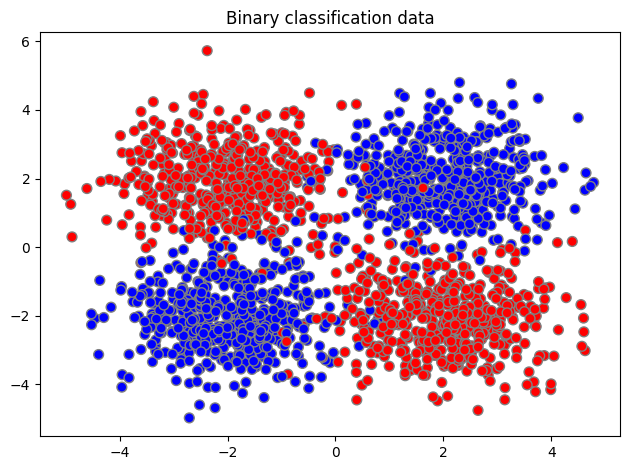

In [5]:
# Generate data
input, input_with_bias, output = generate_dataset()

# plot
fig, ax = plt.subplots()

title = "Binary classification data"
colors = ['red' if y else 'blue' for y in output]
plot_posterior_predictive_preNN(ax, input, title, colors )

In [6]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [7]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    if (print_verbose):
      print(params)
    flat_params, unflatten_fn = ravel_pytree(params)
    if (print_verbose):
      print(flat_params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [8]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [16,16], 1
model_dims = [input_dim, *hidden_dims, output_dim]
if (print_verbose):
  print(model_dims)
model, flat_params, unflatten_fn, apply_fn = get_mlp_flattened_params(model_dims)
if (print_verbose):
  print(flat_params.shape)


# Some model parameters and helper funciton
state_dim, emission_dim = flat_params.size, output_dim
sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x))
initial_sigma2 = .1
dynamic_sigma = 1e-4

# Run CMGF-EKF to train the MLP Classifier
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim) * initial_sigma2
dynamics_function=lambda w, x: w
dynamics_covariance=jnp.eye(state_dim) * dynamic_sigma
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

cmgf_ekf_params = ParamsGGSSM(
     initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)
cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, EKFIntegrals(), output, inputs=input)

# Extract history of filtered weight values
w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances

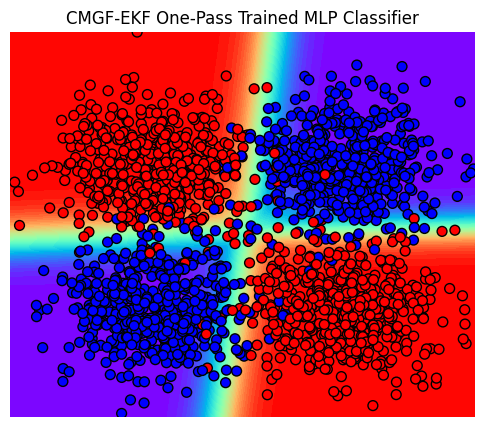

In [9]:
# Evaluate the trained MLP on input_grid
Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, input, output, title, input_grid, Z);

In [10]:
import matplotlib.animation as animation
from IPython.display import HTML

In [11]:
def animate(i):
    ax.cla()
    c = i * 3
    w_curr = w_means[i+3+c]
    Zi = posterior_predictive_grid(input_grid, w_means[i+4+c], sigmoid_fn)
    title = f'EKF-DDN ({i+4+c}/2000)'
    plot_posterior_predictive(ax, input[:i+4+c], output[:i+4+c], title, input_grid, Zi)
    return ax


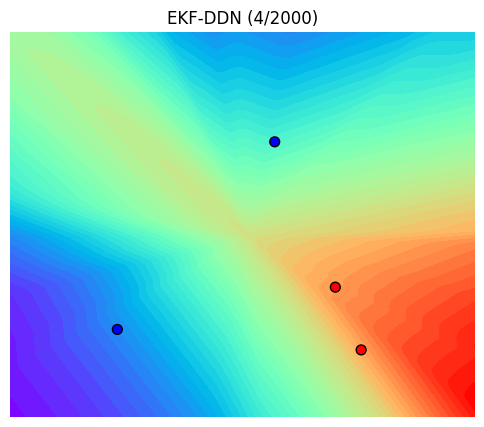

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate, frames=500, interval=50)
anim.save("cmgf_mlp_classifier.mp4", dpi=200, bitrate=-1, fps=15)

In [13]:
HTML(anim.to_html5_video())